# Analyse de l'influence des distributions des temps inter-véhiculaires sur un axe routier

Paramètres de simulation:
- 1 voie
- longueur de la voie : 15900 m
- présence d'outils de contrôle de la circulation : non
- paramètres de distribution 
    <br/> dn -> N(8.33, 1) [m]
    <br/> longueur -> N(7, 1) [m]
    <br/> vitesse -> N(14, 3) [m.s^-1]
    <br/> t -> N(2, 0.5) [s]
- durée de la simulation : 500 s = 5000 1/10s   
- seed pour reproductibilité : 45

import des librairies:

In [1]:
import sys
sys.path.append('/Users/lionel/Documents/Cours Polytechnique Montréal/Maitrise/github/projetmaitrise/modules') 
import numpy as np  
import network, simulation 
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics


OpenCV library could not be loaded (video replay functions will not be available)


Récupération des fichiers initiaux

In [2]:
world = network.World.load('inputData/simple-net.yml')  
sim = simulation.Simulation.load('inputData/config.yml')

tracé des trajectoires selon les différentes valeurs des distribution pour les headway

- headways -> Exp(1.8, 1)
</br> On décalle la distribution à 1s % les temps inter-véhiculaires produits ne seront pas inférieurs à cette valeur

trying headway = 0.8
123 289432
trying headway = 0.9
121 280636


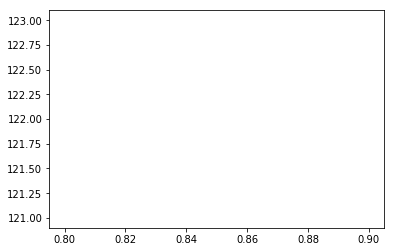

In [7]:
# liste des headways a essayer:
# headways = [x for x in np.arange(.5,2.1,.1)]
headways = [.8, .9]
for h in headways:
    # modification des paramètres dans simple-net.yml
    # au cas ou
    world = network.World.load('inputData/simple-net.yml')  
    
    world.userInputs[0].distributions['headway'].scale = h

    # running the simulation
    world = makesimulation.run(world, sim)
    print('trying headway = {}'.format(h))
    
    #get number of interactions
    interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)
    c = 0 # nombre d'interaction
    s = 0 # duree moyenne des interactions
    interactionLength = []
    for pair in interactionDuration:
        if interactionDuration[pair][0] !=0:
            c += interactionDuration[pair][0]
            s += sum(interactionDuration[pair][1:])
            interactionLength.append(interactionDuration[pair][1:])
    print(c, s)
    
    plt.plot(h, c)

plt.show()
    
    

<br/> Nombre de véhicules simulés/Nombre de véhicules générés : 

In [29]:
print(str(len(world.getNotNoneVehiclesInWorld()[0])) + '/'+ str(len(world.users)))

152/268


Distribution des headways observés

(array([1.07475635, 0.93796917, 0.72301791, 0.50806664, 0.33219742,
        0.41036151, 0.1563282 , 0.21495127, 0.19541024, 0.09770512,
        0.05862307, 0.13678717, 0.05862307, 0.01954102, 0.03908205,
        0.03908205, 0.01954102, 0.05862307, 0.05862307, 0.0781641 ,
        0.        , 0.        , 0.        , 0.        , 0.01954102]),
 array([1.01845862, 1.20940784, 1.40035705, 1.59130627, 1.78225548,
        1.9732047 , 2.16415392, 2.35510313, 2.54605235, 2.73700156,
        2.92795078, 3.11889999, 3.30984921, 3.50079842, 3.69174764,
        3.88269685, 4.07364607, 4.26459528, 4.4555445 , 4.64649371,
        4.83744293, 5.02839214, 5.21934136, 5.41029057, 5.60123979,
        5.792189  ]),
 <a list of 25 Patch objects>)

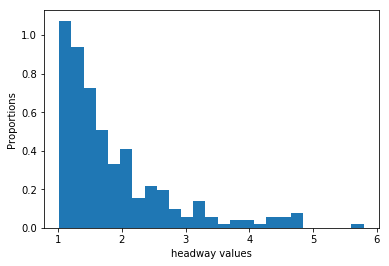

In [30]:
h = analysis.getHeadwayValues(world)
plt.xlabel('headway values')
plt.ylabel('Proportions')
plt.hist(h[0], density=True, bins = 25)

# print(statistics.mean(h[0]))
# print(statistics.mean(world.userInputs[0].headways))

Distribution des min des distances inter-véhiculaires, pour une coexistence d'une durée minimale de 2 min = 1200 1/10s

In [31]:
d = analysis.getMinDistanceBetweenEachPairC F(world, 1200)

(array([ 2.,  4.,  9., 11., 18., 18., 13.,  9., 11.,  5.,  4.,  3.,  3.,
         3.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  2.]),
 array([13.25974847, 14.52629299, 15.79283751, 17.05938204, 18.32592656,
        19.59247108, 20.85901561, 22.12556013, 23.39210465, 24.65864918,
        25.9251937 , 27.19173822, 28.45828275, 29.72482727, 30.99137179,
        32.25791632, 33.52446084, 34.79100536, 36.05754989, 37.32409441,
        38.59063893, 39.85718346, 41.12372798]),
 <a list of 22 Patch objects>)

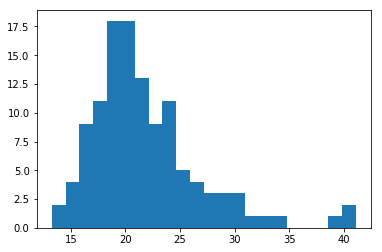

In [32]:
plt.hist(d, bins=22, density=False)# 'min distance between users', 'proportions')

Nombre d'interactions et leur durée observées à une distance < 25 m

In [36]:
interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)

In [37]:
c = 0 # nombre d'interaction
s = 0 # duree moyenne des interactions
interactionLength = []
for pair in interactionDuration:
    if interactionDuration[pair][0] !=0:
        c += interDuration[pair][0]
        s += sum(interactionDuration[pair][1:])
        interactionLength.append(interactionDuration[pair][1:])
print(c, s)

KeyError: (140, 141)

Durée moyenne des interactions

In [ ]:
if c != 0:
    print(s/c)

distribution de la durée des interactions (ayant lieu a une distance < 25 m)
</br>**a voir**

In [ ]:
plt.hist(interactionLength, bins=3, density=False)

Tracé des courbes de TTC

minTTCValues = analysis.getTTCValuesForEachPairOfVehicles(world, sim, plot=True)[1]

Distribution des TTC min

plt.hist(minTTCValues, bins=30, density=True)
minTTCValues

- headways -> Exp(2, 1)